## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration

In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

## Distortion Correction based on Camera Calibration Result

In [3]:
def undistort(img):
    img_cp = img.copy()
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return cv2.undistort(img_cp, mtx, dist, None, mtx)

True

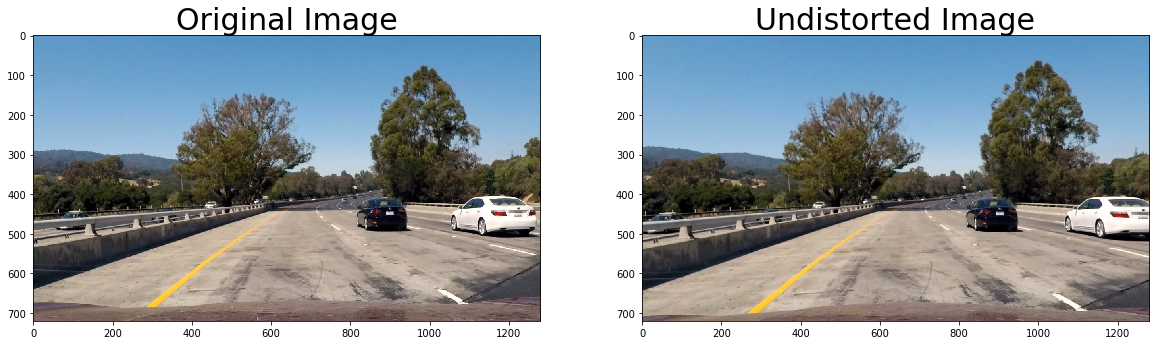

In [10]:
img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
undistorted_img = undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)
cv2.imwrite('undistorted_test1.png', undistorted_img)

# Color Tranformation

Text(0.5,1,'Binary Image')

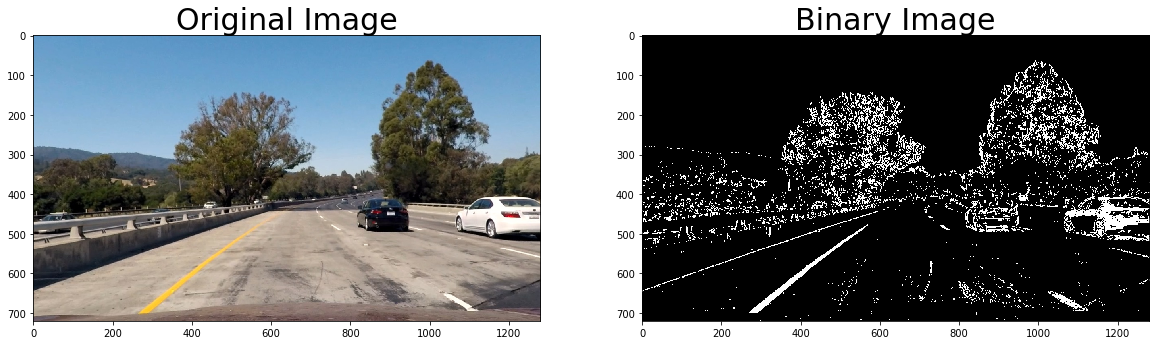

In [11]:
def color_transform(img, s_thresh=(170, 255), sx_thresh=(20, 100)):    
    img_cp = img.copy()
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img_cp, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    
binary_img = color_transform(undistorted_img)
cv2.imwrite('binary_img.png', binary_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_img, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)

# Perspective Transformation

Text(0.5,1,'Warped Image')

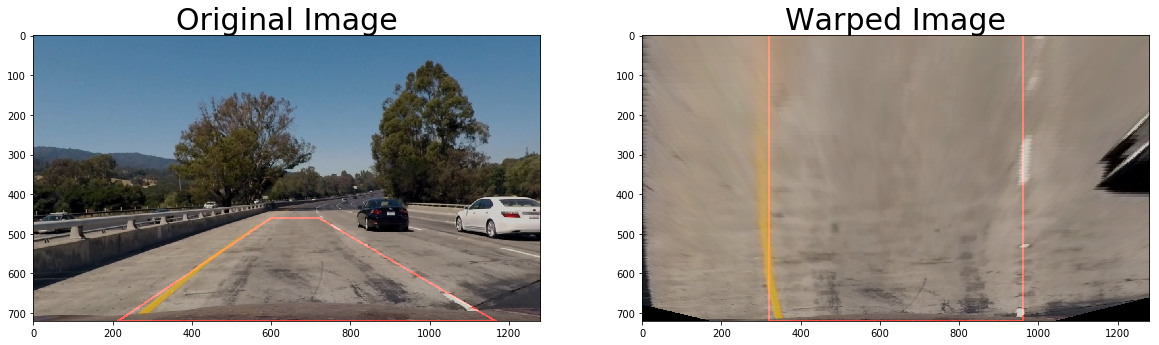

In [48]:
def warper(img, src, dst):
    img_cp = img.copy()
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return cv2.warpPerspective(img_cp, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST), M, Minv

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    img_init_cp = initial_img.copy()
    img_cp = img.copy()
    return cv2.addWeighted(img_init_cp, α, img_cp, β, γ)

def draw_lines(img, points, color=[255, 0, 0], thickness=3, dim=3):
    img_cp = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if len(points) > 2:
        cv2.line(img_cp, (points[0][0], points[0][1]), (points[len(points) - 1][0], points[len(points) - 1][1]), color, thickness)
    for i in range(1, len(points)):
        cv2.line(img_cp, (points[i - 1][0], points[i - 1][1]), (points[i][0], points[i][1]), color, thickness)
    return img_cp


img_size = (undistorted_img.shape[1], undistorted_img.shape[0])

src = np.float32([
    [img_size[0] / 2 - 40, img_size[1] / 2 + 100],
    [img_size[0] / 6, img_size[1]],
    [img_size[0] * 5 / 6 + 100, img_size[1]],
    [img_size[0] / 2 + 80, img_size[1] / 2 + 100]
])

dst = np.float32([
    [img_size[0] / 4, 0],
    [img_size[0] / 4, img_size[1]],
    [img_size[0] * 3 / 4, img_size[1]],
    [img_size[0] * 3 / 4, 0]
])

warped_binary, M, Minv = warper(binary_img, src, dst)
warped_img, M, Minv = warper(undistorted_img, src, dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
original_img_with_area = weighted_img(draw_lines(undistorted_img, src), undistorted_img)
cv2.imwrite('original_img_with_area.png', original_img_with_area)
warped_img_with_area = weighted_img(draw_lines(warped_img, dst), warped_img)
cv2.imwrite('warped_img_with_area.png', warped_img_with_area)
ax1.imshow(original_img_with_area)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_img_with_area)
ax2.set_title('Warped Image', fontsize=30)

# Line Boundary Detection

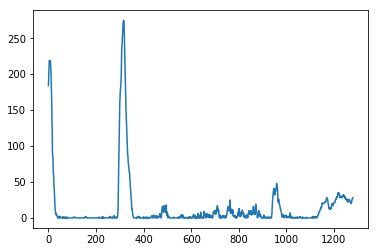

In [49]:
def hist(img):
    return np.sum(img[img.shape[0]//2:,:], axis=0)

# Create histogram of image binary activations
histogram = hist(warped_binary)
cv2.imwrite('histogram.png', histogram)
# Visualize the resulting histogram
plt.plot(histogram)

## Sliding Window I

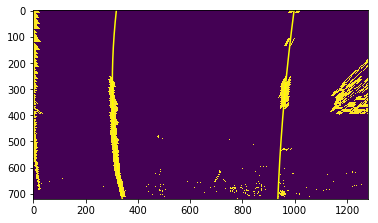

In [57]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    binary_warped_cp = binary_warped.copy()
    out_img = np.dstack((binary_warped_cp, binary_warped_cp, binary_warped_cp))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # 
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, draw=False):
    binary_warped_cp = binary_warped.copy()
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped_cp)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if draw:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty


out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped_binary, True)
cv2.imwrite('sliding_window_I.png', out_img)
plt.imshow(warped_binary)

## Sliding Window II

In [58]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

# window_centroids = find_window_centroids(warped_binary, window_width, window_height, margin)

# # If we found any window centers
# if len(window_centroids) > 0:

#     # Points used to draw all the left and right windows
#     l_points = np.zeros_like(warped_binary)
#     r_points = np.zeros_like(warped_binary)

#     # Go through each level and draw the windows 	
#     for level in range(0,len(window_centroids)):
#         # Window_mask is a function to draw window areas
#         l_mask = window_mask(window_width,window_height,warped_binary,window_centroids[level][0],level)
#         r_mask = window_mask(window_width,window_height,warped_binary,window_centroids[level][1],level)
#         # Add graphic points from window mask here to total pixels found 
#         l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
#         r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

#     # Draw the results
#     template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
#     zero_channel = np.zeros_like(template) # create a zero color channel
#     template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
#     warpage= np.dstack((warped_binary, warped_binary, warped_binary))*255 # making the original road pixels 3 color channels
#     output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    
# # If no window centers found, just display orginal road image
# else:
#     output = np.array(cv2.merge((warped_binary,warped_binary,warped_binary)),np.uint8)

# # Display the final results
# plt.imshow(output)
# plt.title('window fitting results')
# plt.show()


## Sliding Window III

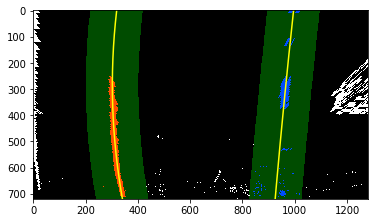

In [59]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) == 0 or len(rightx) == 0:
        return None, None, None, None

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fitx, right_fitx, ploty = search_around_poly(warped_binary, left_fit, right_fit)
cv2.imwrite('sliding_window_III.png', result)
# View your output
plt.imshow(result)

# Curvature Computation and Vehicle Relative Position

In [60]:
def measure_curvature_real(binary_warped):
    
    binary_warped_cp = binary_warped.copy()
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped_cp)

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    y_eval = max(np.max(lefty), np.max(righty))
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    histogram = hist(binary_warped_cp)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    offset_center = ((rightx_base + leftx_base) / 2 - 640) * xm_per_pix
    return left_curverad, right_curverad, offset_center

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, offset_center = measure_curvature_real(warped_binary)

print(left_curverad, 'm', right_curverad, 'm', offset_center, 'm')

837.658280746 m 2576.79587652 m -0.0132142857143 m


# Lane Boundary Plot

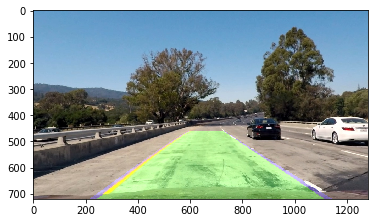

In [61]:
def mark_lane(warped_binary, Minv, undistorted_img, left_fitx, right_fitx, ploty):
    road_warp = np.zeros_like(warped_binary).astype(np.uint8)
    color_road_warp = np.dstack((road_warp, road_warp, road_warp))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flip(np.transpose(np.vstack([right_fitx, ploty])), axis=0)])
    points = np.hstack((pts_left, pts_right))

    cv2.polylines(color_road_warp, np.int_([points]), isClosed=False, color=(0, 0, 255), thickness=40)

    cv2.fillPoly(color_road_warp, np.int_([points]), color=[0,255,0])

    transformed_color_road_warp = cv2.warpPerspective(color_road_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0]), flags=cv2.INTER_NEAREST)
    return cv2.addWeighted(undistorted_img, 1, transformed_color_road_warp, 0.3, 0)

marked_lane = mark_lane(warped_binary, Minv, undistorted_img, left_fitx, right_fitx, ploty)
cv2.imwrite('lane_boundary.png', marked_lane)
plt.imshow(marked_lane)
plt.show()

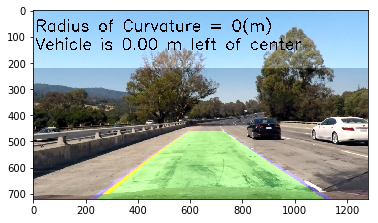

In [62]:
def draw_info_board(img, curvature, offset):
    img_cp = img.copy()
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = [(10,80), (10, 150)]
    fontScale              = 2
    fontColor              = (0,0,0)
    lineType               = 4
    
    temp = np.zeros_like(img_cp).astype(np.uint8)
    points = np.array([[0, 0], [0, 200], [1280, 200], [1280, 0]])
    cv2.polylines(temp, np.int_([points]), isClosed=True, color=(169,169,169), thickness=40)
    cv2.fillPoly(temp, np.int_([points]), color=[169,169,169])
    result = cv2.addWeighted(img_cp, 1, temp, 0.3, 0)
    
    cv2.putText(result, "Radius of Curvature = %d(m)" % curvature, bottomLeftCornerOfText[0], font, fontScale, fontColor, lineType)
    if offset > 0:
        orientation = 'right'
    else:
        orientation = 'left'
        offset = -offset
    cv2.putText(result, "Vehicle is %.2f m %s of center" % (offset, orientation), bottomLeftCornerOfText[1], font, fontScale, fontColor, lineType)
    return result

lane_boundary_with_info = draw_info_board(marked_lane, 0, 0)
cv2.imwrite('lane_boundary_with_info.png', lane_boundary_with_info)
plt.imshow(lane_boundary_with_info)
plt.show()

# Pipeline for single frame

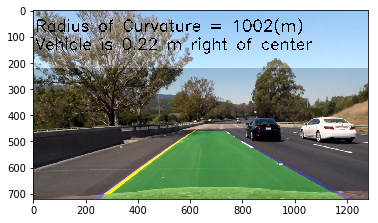

In [65]:
detected = False
prev_left_fit = None
prev_right_fit = None

def pipeline(frame):
    frame_cp = frame.copy()
    undistorted_img = undistort(frame_cp)
    
    img_size = (undistorted_img.shape[1], undistorted_img.shape[0])

    src = np.float32([
        [img_size[0] / 2 - 55, img_size[1] / 2 + 100],
        [img_size[0] / 6 + 20, img_size[1]],
        [img_size[0] * 5 / 6 + 60, img_size[1]],
        [img_size[0] / 2 + 75, img_size[1] / 2 + 100]
    ])

    dst = np.float32([
        [img_size[0] / 4, 0],
        [img_size[0] / 4, img_size[1]],
        [img_size[0] * 3 / 4, img_size[1]],
        [img_size[0] * 3 / 4, 0]
    ])

    binary_img = color_transform(undistorted_img)

    warped_binary, M, Minv = warper(binary_img, src, dst)
    
    warped_binary_cp = warped_binary.copy()
    
    global detected
    global prev_left_fit
    global prev_right_fit
    if detected:
        result, left_fitx, right_fitx, ploty = search_around_poly(warped_binary_cp, prev_left_fit, prev_right_fit)
        if result is None:
            out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped_binary_cp)
            prev_left_fit = left_fit
            prev_right_fit = right_fit
    else:
        out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped_binary_cp)
        prev_left_fit = left_fit
        prev_right_fit = right_fit
        detected = True
    
    left_curverad, right_curverad, offset_center = measure_curvature_real(warped_binary)
    
    result = mark_lane(warped_binary, Minv, undistorted_img, left_fitx, right_fitx, ploty)
    
    return draw_info_board(result, (left_curverad + right_curverad) / 2, offset_center)

img = cv2.imread('../test_images/test6.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(pipeline(img))
plt.show()

# Pipeline for Streaming Videos

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 18min 58s, sys: 29.2 s, total: 19min 27s
Wall time: 19min 8s


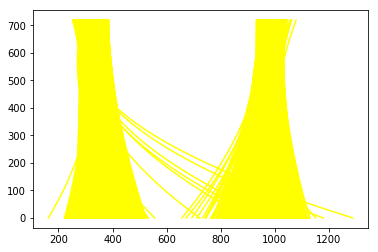

In [66]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('../project_video.mp4')
clips = clip2.fl_image(pipeline)
%time clips.write_videofile(video_output, audio=False)

In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
CPU times: user 7min 11s, sys: 9.76 s, total: 7min 21s
Wall time: 7min 14s


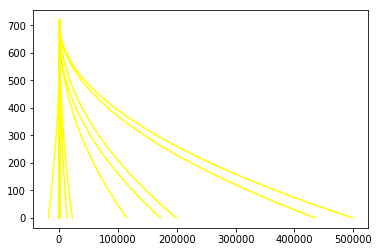

In [68]:
challenge_video_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('../challenge_video.mp4')
clips = clip2.fl_image(pipeline)
%time clips.write_videofile(challenge_video_output, audio=False)

In [69]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video harder_challenge_video_output.mp4.
Moviepy - Writing video harder_challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready harder_challenge_video_output.mp4
CPU times: user 18min 43s, sys: 33.2 s, total: 19min 17s
Wall time: 18min 58s


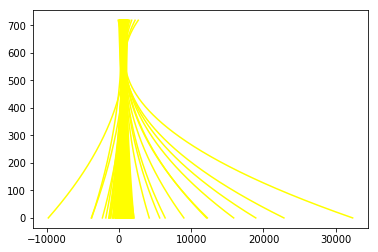

In [70]:
harder_challenge_video_output = 'harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('../harder_challenge_video.mp4')
clips = clip2.fl_image(pipeline)
%time clips.write_videofile(harder_challenge_video_output, audio=False)

In [71]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))